# Datathon

In [2]:
# Libraries to be used in the model
import pandas as pd
import numpy as np
import seaborn as sn
import re 

# Ploting libraries
import matplotlib.pyplot as plt

# Model Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBRegressor

# Metrics or statistics to use
from statistics import mean
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, accuracy_score, roc_auc_score, mean_squared_error,confusion_matrix,classification_report

######################################

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
import sklearn
sklearn.set_config(display='diagram')

In [ ]:
# Get unique values per column
def print_unique_values_per_column(d):
    for c in d.columns:
        if (d[c].nunique() < 30):
            print(c, d[c].nunique(), d[c].dtype, d[c].unique())
        else:
            print(c, d[c].nunique(), d[c].dtype)

# Print missing values
def print_missing_values(d):
    missing_total = d.isnull().sum().sort_values(ascending=False)
    missing_percent = (d.isnull().sum()/d.isnull().count()).sort_values(ascending=False)
    missing = pd.concat([missing_total, missing_percent], axis=1, keys=['Total', 'Percent'])
    missing = missing[missing['Percent'] > 0]
    print(missing)

def get_columns_with_nulls(d):
    missing_total = d.isnull().sum().sort_values(ascending=False)
    missing_percent = (d.isnull().sum()/d.isnull().count()).sort_values(ascending=False)
    missing = pd.concat([missing_total, missing_percent], axis=1, keys=['Total', 'Percent'])
    missing = missing[missing['Percent'] > 0]
    return missing.index.values

# Custom accuracy evaluation
def accuracy_score(estimator, X, y):
    estimator.fit(X, y)
    y_pred = estimator.predict(X)
    accuracy = mean(1 - mean_absolute_error(y, y_pred)/y_pred)
    return accuracy

## Import Datasets

In [99]:
train = pd.read_csv('train_data.csv', parse_dates=['ofd_date'], dayfirst=True)
train.shape

(11309, 13)

In [88]:
test = pd.read_csv('test.csv', index_col='Unnamed: 0', parse_dates=['ofd_date'], dayfirst=True)
test.shape

(2389, 11)

In [89]:
train.shape

(11309, 13)

In [90]:
train.dtypes

ofd_date        datetime64[ns]
country_code            object
fc_codes                object
station_code            object
OFD                      int64
Slam                     int64
Earlies_Exp              int64
Earlies_Rec              int64
MNR_SNR_Exp              int64
Rollover                 int64
Returns                  int64
R_Sideline               int64
Sideline                 int64
dtype: object

In [10]:
train.isnull().sum()

ofd_date        0
country_code    0
fc_codes        0
station_code    0
OFD             0
Slam            0
Earlies_Exp     0
Earlies_Rec     0
MNR_SNR_Exp     0
Rollover        0
Returns         0
R_Sideline      0
Sideline        0
dtype: int64

In [171]:
train.describe().round(0)

,OFD,Slam,Earlies_Exp,Earlies_Rec,MNR_SNR_Exp,Rollover,Returns,R_Sideline,Sideline
count,11309.0,11309.0,11309.0,11309.0,11309.0,11309.0,11309.0,11309.0,11309.0
mean,16108.0,16050.0,645.0,653.0,216.0,232.0,162.0,181.0,176.0
std,7391.0,7243.0,605.0,609.0,475.0,603.0,304.0,497.0,485.0
min,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25%,11298.0,11337.0,220.0,225.0,76.0,51.0,40.0,0.0,0.0
50%,14644.0,14617.0,463.0,475.0,120.0,87.0,81.0,2.0,2.0
75%,19113.0,19120.0,867.0,876.0,208.0,183.0,148.0,115.0,119.0
max,50365.0,50421.0,4934.0,5219.0,17411.0,18839.0,5479.0,8090.0,8121.0


In [11]:
## 1) Create the target column
train["Target"] = train['Earlies_Exp'] - train['MNR_SNR_Exp']
train.head()

,ofd_date,country_code,fc_codes,station_code,OFD,Slam,Earlies_Exp,Earlies_Rec,MNR_SNR_Exp,Rollover,Returns,R_Sideline,Sideline,Target
0,2021-06-30,C,"F6, F8, F14, F17",D33,14594,14568,782,896,615,767,35,2,4,167
1,2021-06-30,C,"F6, F8, F9, F14, F17, F18",D37,12736,13111,655,823,211,29,17,2,1,444
2,2021-06-30,C,"F1, F4, F6, F7, F13, F15, F16",D34,14562,15651,1028,1910,225,35,47,3,1,803
3,2021-06-30,C,"F2, F6, F7, F10, F12, F13, F14, F15, F19",D45,11165,11467,514,769,56,39,29,0,1,458
4,2021-06-30,C,"F6, F8, F13, F14, F17",D50,10006,10423,399,842,52,60,65,1,1,347


## EDA (Exploratory Data Analysis)

In [12]:
pd.DataFrame.set_index(train.loc[:, ['ofd_date', 'Target']], 'ofd_date').describe() #.plot(figsize=(12,4))

,Target
count,11309.000000
mean,428.840481
std,718.831072
min,-16625.000000
25%,88.000000
50%,298.000000
75%,660.000000
max,4878.000000


In [13]:
train.columns

Index(['ofd_date', 'country_code', 'fc_codes', 'station_code', 'OFD', 'Slam',
       'Earlies_Exp', 'Earlies_Rec', 'MNR_SNR_Exp', 'Rollover', 'Returns',
       'R_Sideline', 'Sideline', 'Target'],
      dtype='object')

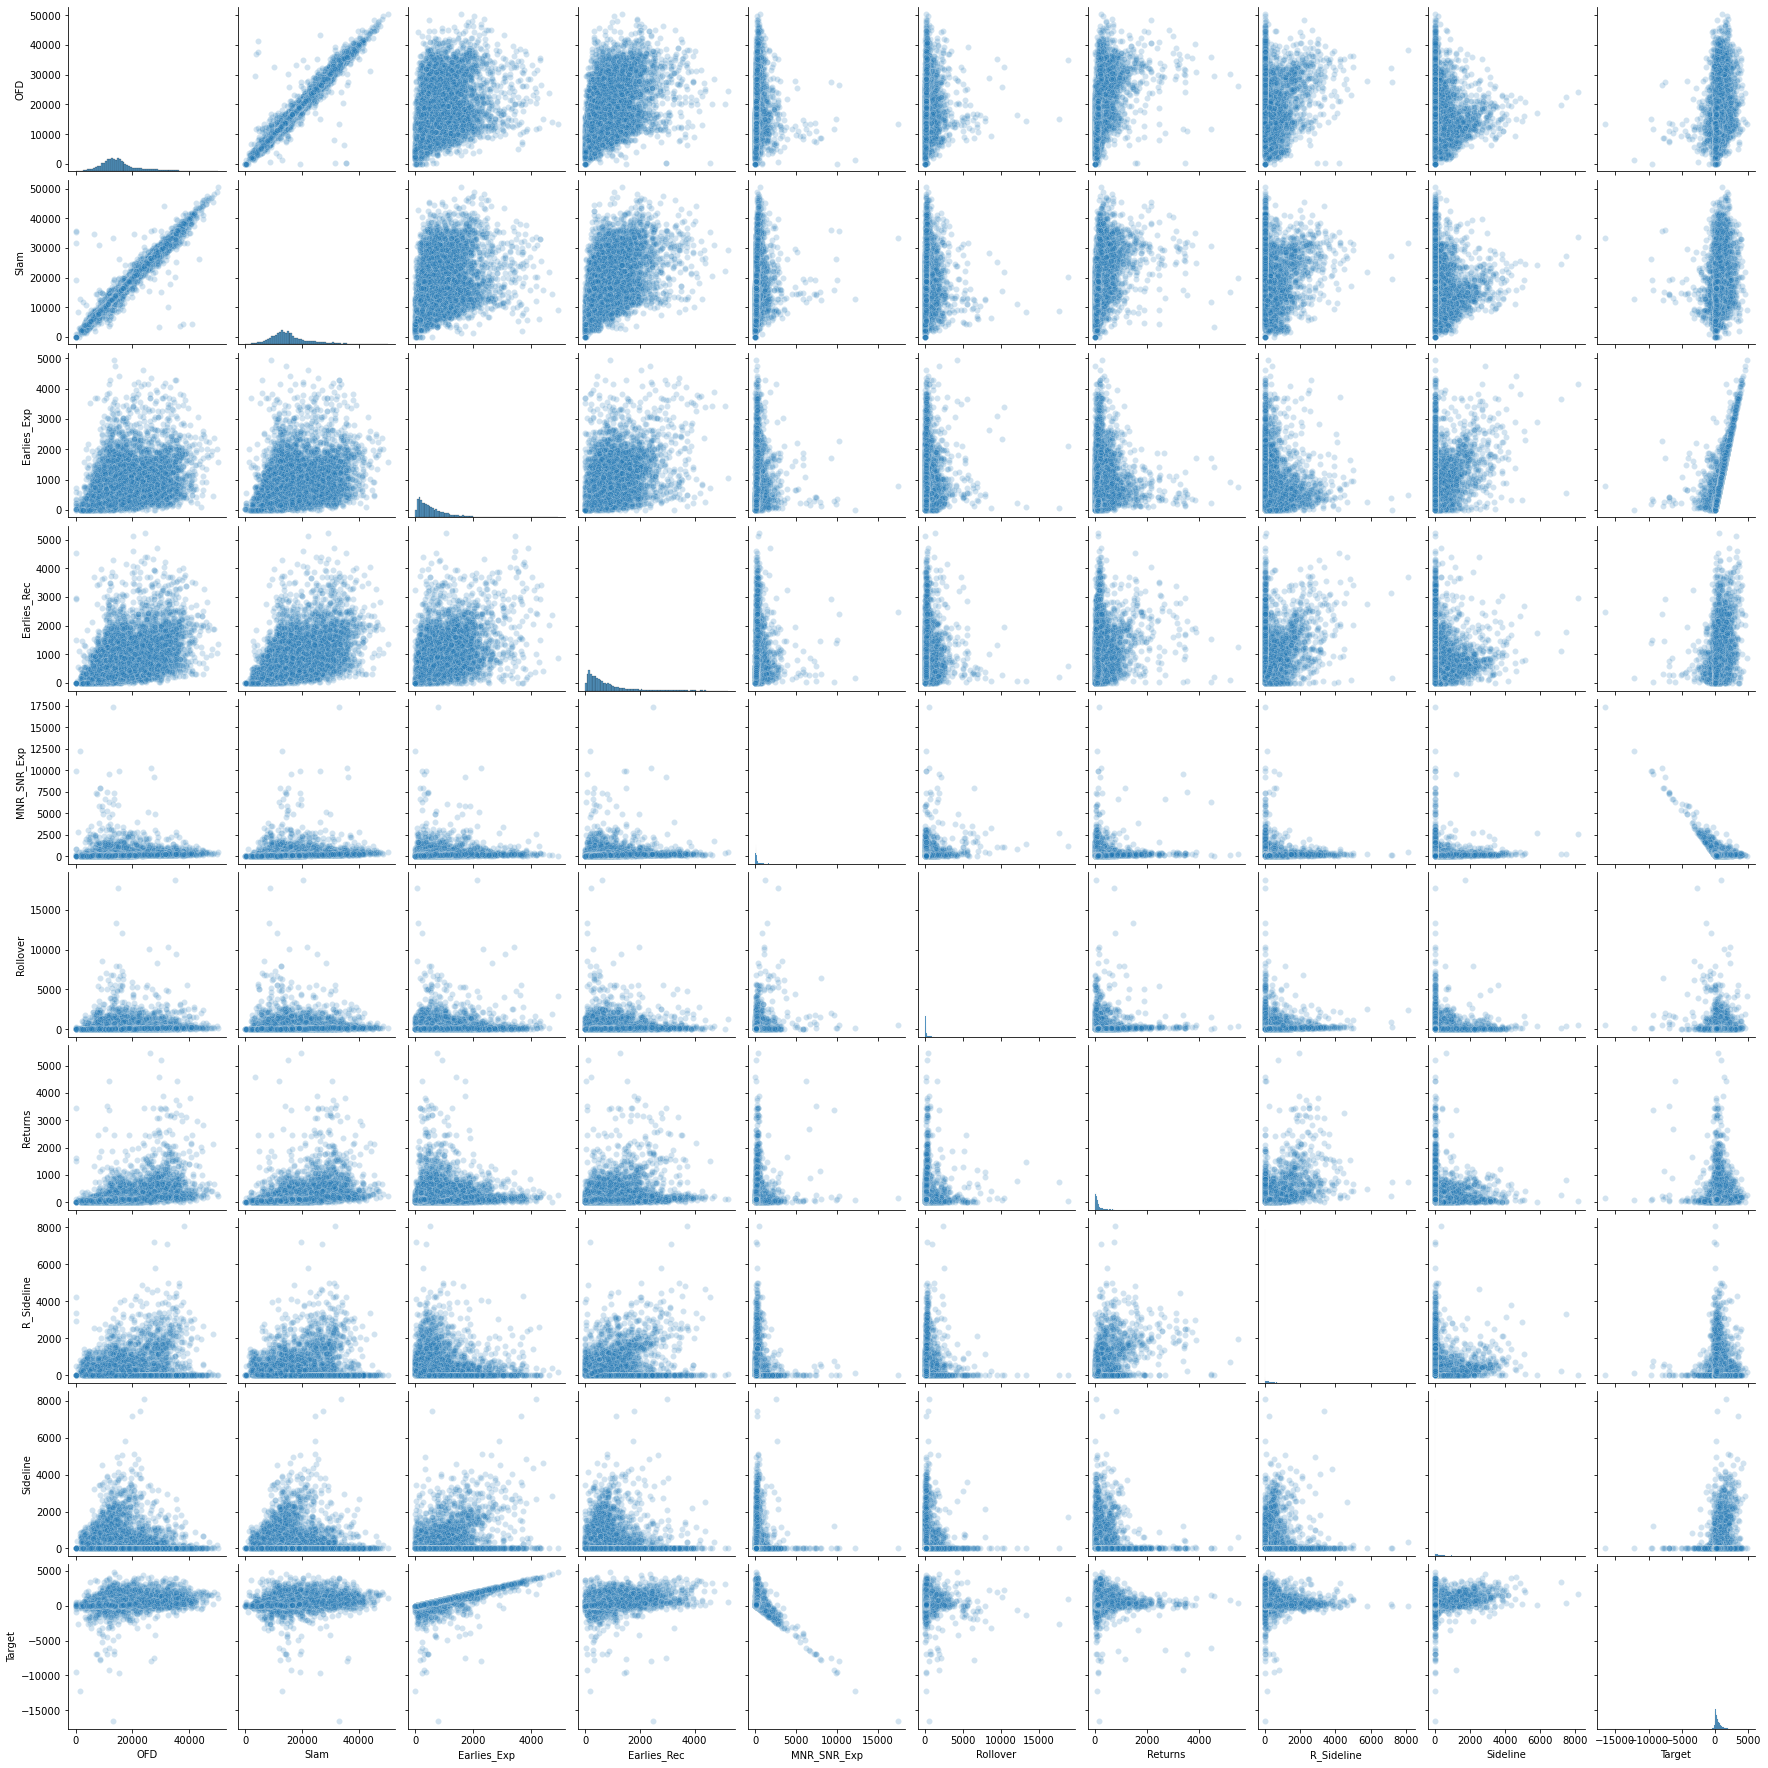

In [14]:
numeric_columns = ['OFD', 'Slam', 'Earlies_Exp', 'Earlies_Rec', 'MNR_SNR_Exp', 'Rollover', 'Returns',
       'R_Sideline', 'Sideline', 'Target']

sn.pairplot(train[numeric_columns],kind="scatter", plot_kws=dict( alpha=0.2))

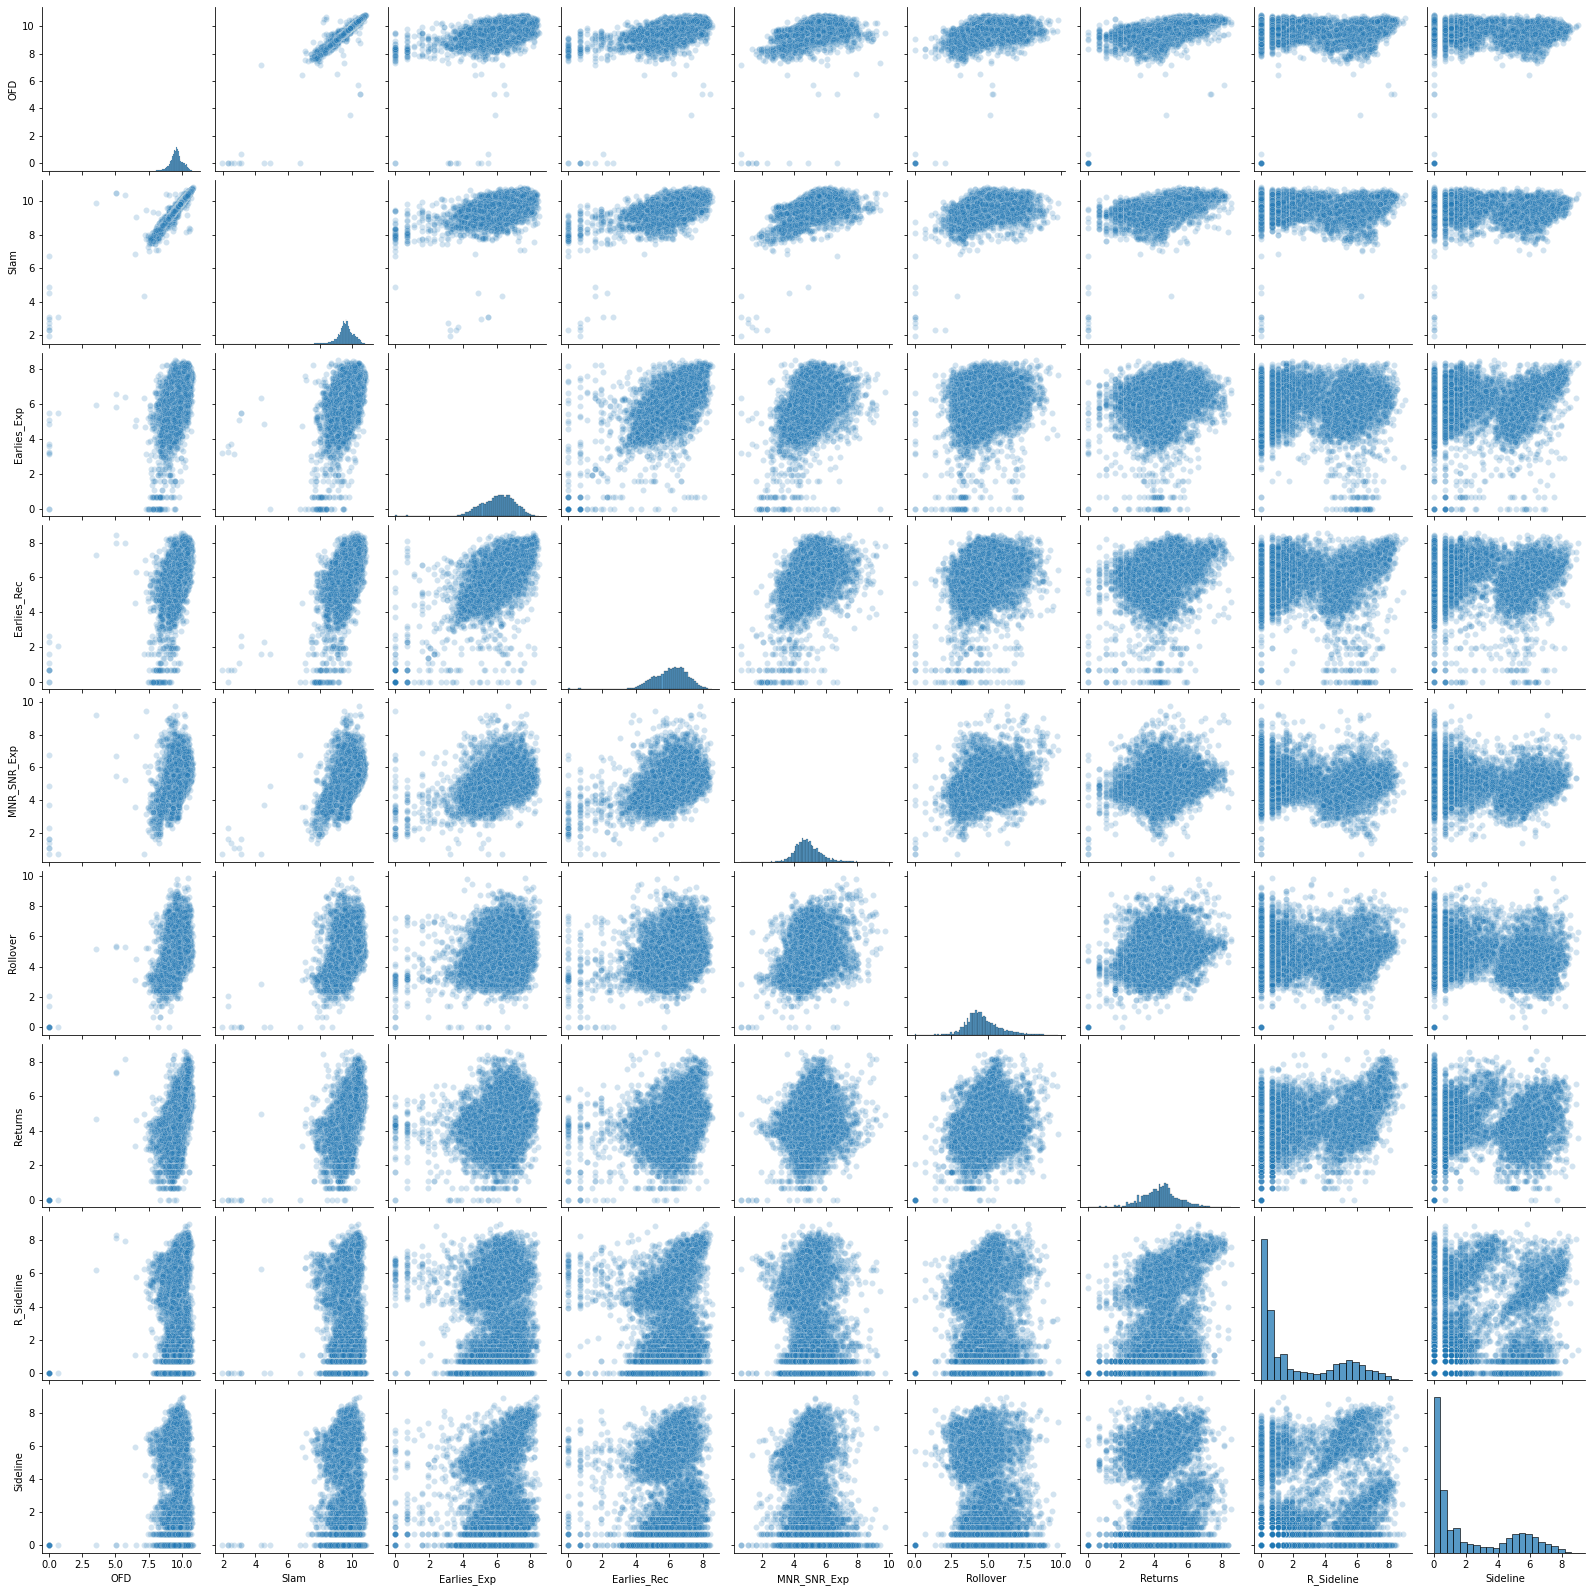

In [15]:
numeric_df = train[numeric_columns[:-1]].copy()
numeric_df = numeric_df.apply(lambda x: np.log(x+1))

sn.pairplot(numeric_df,kind="scatter", plot_kws=dict( alpha=0.2))

In [18]:
rob = RobustScaler()
train_2 = rob.fit_transform(train[numeric_columns])
train_2 = pd.DataFrame(train_2, columns=numeric_columns)
# train_2.describe

In [20]:
for col, ax in zip(numeric_columns, axes):
    print(col)

OFD
Slam
Earlies_Exp
Earlies_Rec
MNR_SNR_Exp
Rollover
Returns
R_Sideline
Sideline
Target


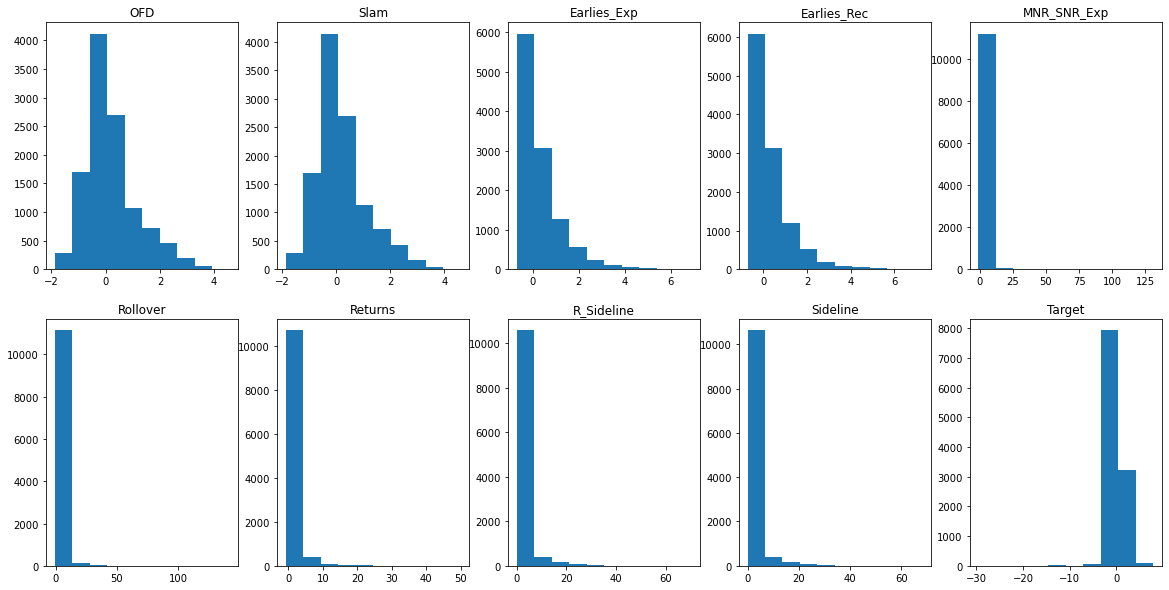

In [21]:
fig, ax = plt.subplots(2, 5, figsize=(20,10))

axes = ax.ravel()

for col, ax in zip(numeric_columns, axes):
    if col == 'Target':
        ax.hist(train_2[col])
    else:    
        ax.hist(train_2[col])
    ax.set_title(col)


<AxesSubplot:xlabel='ofd_date'>

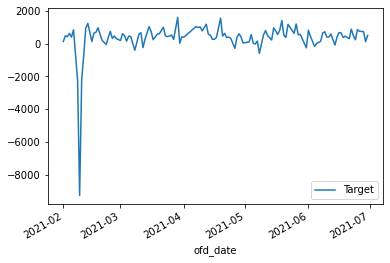

In [24]:
pd.DataFrame.set_index(train.loc[train['station_code'] == 'D35', ['ofd_date', 'Target']], 'ofd_date').groupby('ofd_date').mean().plot()

<AxesSubplot:xlabel='ofd_date'>

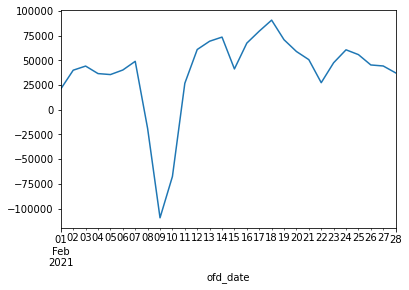

In [25]:
df_train_2 = pd.DataFrame.set_index(train.loc[:, ['ofd_date', 'Target', 'Earlies_Exp', 'MNR_SNR_Exp']], 'ofd_date').groupby('ofd_date').sum()
df_train_2.loc['2021-02-01':'2021-02-28']['Target'].plot()

In [26]:
train.dtypes

ofd_date        datetime64[ns]
country_code            object
fc_codes                object
station_code            object
OFD                      int64
Slam                     int64
Earlies_Exp              int64
Earlies_Rec              int64
MNR_SNR_Exp              int64
Rollover                 int64
Returns                  int64
R_Sideline               int64
Sideline                 int64
Target                   int64
dtype: object

## Data Cleaning and Feature Engineering

In [27]:
## 3) Create the column of days of the week with the following codes
"""
0 = Monday
1 = Tuesday
2 = Wednesday
3 = Thrusday
4 = Friday
5 = Saturday
6 = Sunday
""" 
train["dayOfWeek"] = train['ofd_date'].dt.day_of_week
# train.tail()

<AxesSubplot:xlabel='dayOfWeek'>

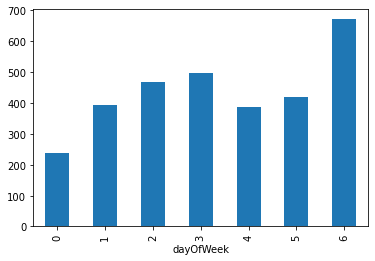

In [28]:
train.groupby('dayOfWeek').mean()['Target'].plot.bar()

In [29]:
new_train = train.iloc[:, 1:]
new_train.head(2)

,country_code,fc_codes,station_code,OFD,Slam,Earlies_Exp,Earlies_Rec,MNR_SNR_Exp,Rollover,Returns,R_Sideline,Sideline,Target,dayOfWeek
0,C,"F6, F8, F14, F17",D33,14594,14568,782,896,615,767,35,2,4,167,2
1,C,"F6, F8, F9, F14, F17, F18",D37,12736,13111,655,823,211,29,17,2,1,444,2


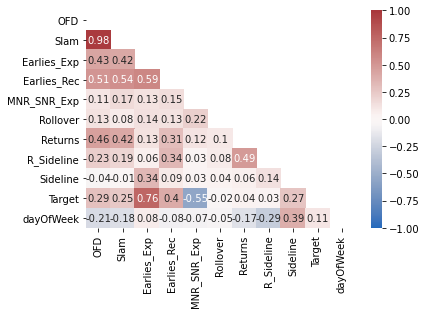

In [30]:
# Checking features correlation

matrix = new_train.corr().round(2)
matrix
mask = np.triu(np.ones_like(matrix, dtype=bool))
sn.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

In [31]:
new_train['fc_codes'].str.get_dummies(sep=', ').corr()

,F1,F10,F11,F12,F13,F14,F15,F16,F17,F18,...,F51,F52,F53,F54,F55,F56,F6,F7,F8,F9
F1,1.000000,-0.059529,-0.048474,-0.048270,0.776881,-0.100154,0.182285,0.557875,0.138572,-0.034089,...,-0.127650,-0.120184,-0.127650,-0.112467,-0.104431,-0.095985,0.646875,0.430354,0.015769,-0.069247
F10,-0.059529,1.000000,0.393602,0.391950,0.093121,0.378196,0.640110,-0.033210,0.147094,-0.019044,...,-0.071314,-0.067143,-0.071314,-0.062832,-0.058342,-0.053624,0.416543,0.301141,0.146980,0.561041
F11,-0.048474,0.393602,1.000000,-0.021959,-0.062395,0.219216,0.521232,-0.027042,0.202583,-0.015508,...,-0.058070,-0.054674,-0.058070,-0.051163,-0.047507,-0.043665,0.339184,-0.055567,0.453534,0.700017
F12,-0.048270,0.391950,-0.021959,1.000000,0.144899,0.218296,0.519045,-0.026929,-0.048393,-0.015442,...,-0.057826,-0.054444,-0.057826,-0.050948,-0.047308,-0.043482,0.136510,0.395182,-0.048417,-0.031369
F13,0.776881,0.093121,-0.062395,0.144899,1.000000,0.407925,0.221378,0.433403,0.473121,-0.043879,...,-0.164311,-0.154701,-0.164311,-0.144767,-0.134424,-0.123552,0.632195,0.390426,0.371491,-0.089134
F14,-0.100154,0.378196,0.219216,0.218296,0.407925,1.000000,0.203378,-0.055873,0.808465,0.340363,...,-0.119981,-0.112964,-0.119981,-0.105710,-0.098157,-0.090219,0.387523,0.001435,0.808043,0.313934
F15,0.182285,0.640110,0.521232,0.519045,0.221378,0.203378,1.000000,0.408840,0.045261,-0.029752,...,-0.111409,-0.104893,-0.111409,-0.098158,-0.091144,-0.083773,0.540216,0.511912,0.183597,0.542927
F16,0.557875,-0.033210,-0.027042,-0.026929,0.433403,-0.055873,0.408840,1.000000,-0.059596,-0.019017,...,-0.071213,-0.067048,-0.071213,-0.062743,-0.058260,-0.053548,0.415951,0.486665,-0.059626,-0.038631
F17,0.138572,0.147094,0.202583,-0.048393,0.473121,0.808465,0.045261,-0.059596,1.000000,0.319105,...,-0.127974,-0.120489,-0.127974,-0.112752,-0.104696,-0.096229,0.351776,-0.012183,0.754697,0.290135
F18,-0.034089,-0.019044,-0.015508,-0.015442,-0.043879,0.340363,-0.029752,-0.019017,0.319105,1.000000,...,-0.040837,-0.038449,-0.040837,-0.035980,-0.033409,-0.030707,0.238528,-0.039077,0.318944,0.492280


## Initial Data Tranformation 

In [33]:
## Count of FC codes
train.columns

Index(['ofd_date', 'country_code', 'fc_codes', 'station_code', 'OFD', 'Slam',
       'Earlies_Exp', 'Earlies_Rec', 'MNR_SNR_Exp', 'Rollover', 'Returns',
       'R_Sideline', 'Sideline', 'Target', 'dayOfWeek'],
      dtype='object')

In [91]:
# DATA TRANSFORMATION

## 1) Create the target column
train["Target"] = train['Earlies_Exp'] - train['MNR_SNR_Exp']

## 2) Standarized the numerical data (if needed)
for column in ['OFD','Slam','Earlies_Exp','Earlies_Rec','MNR_SNR_Exp','Rollover','Returns','R_Sideline','Sideline']:
    train[column] = (train[column] - train[column].mean()) / train[column].std()
train

## 3) Create the column of days of the week with the following codes
"""
0 = Monday
1 = Tuesday
2 = Wednesday
3 = Thrusday
4 = Friday
5 = Saturday
6 = Sunday
""" 
train["ofd_date"] = pd.to_datetime(train["ofd_date"])
# train["dayOdWeek"] = train['ofd_date'].dt.day_of_week
train["dayOfWeekName"] = train['ofd_date'].dt.day_name()
train = pd.get_dummies(train, prefix = ['day_'], columns = ['dayOfWeekName'])

## 4) Create the colums per FC code.
# train = pd.concat([train, train['fc_codes'].str.get_dummies(sep=', ')], axis=1)
train['fc_codes_count'] = train['fc_codes'].str.split(',').apply(lambda x: len(x))


# 5) Get the categorical data to be separated
train = pd.get_dummies(train, prefix = ['country_'], columns = ['country_code'])
# train = pd.get_dummies(train, prefix = ['station_'], columns = ['station_code'])

# 6) Drop no relevant columns
train = train.drop(columns=['ofd_date','fc_codes', 'Earlies_Exp', 'MNR_SNR_Exp', 'Slam', 'station_code'])

# train.head()


In [67]:
new_train['fc_codes_count'] = new_train['fc_codes'].str.split(',').apply(lambda x: len(x))
new_train.head(1)

,country_code,fc_codes,station_code,OFD,Slam,Earlies_Exp,Earlies_Rec,MNR_SNR_Exp,Rollover,Returns,R_Sideline,Sideline,Target,dayOfWeek,fc_codes_count
0,C,"F6, F8, F14, F17",D33,14594,14568,782,896,615,767,35,2,4,167,2,4


In [50]:
new_train.corr()

,OFD,Slam,Earlies_Exp,Earlies_Rec,MNR_SNR_Exp,Rollover,Returns,R_Sideline,Sideline,Target,dayOfWeek
OFD,1.000000,0.981989,0.431521,0.509715,0.110143,0.126458,0.458285,0.227561,-0.042242,0.290058,-0.214435
Slam,0.981989,1.000000,0.421833,0.541616,0.165681,0.076776,0.419291,0.191049,-0.009396,0.245184,-0.182804
Earlies_Exp,0.431521,0.421833,1.000000,0.591392,0.129943,0.143568,0.133915,0.055334,0.340812,0.755037,0.081855
Earlies_Rec,0.509715,0.541616,0.591392,1.000000,0.146127,0.125590,0.307763,0.336773,0.088371,0.400709,-0.084790
MNR_SNR_Exp,0.110143,0.165681,0.129943,0.146127,1.000000,0.220140,0.115670,0.030232,0.031303,-0.552011,-0.069149
Rollover,0.126458,0.076776,0.143568,0.125590,0.220140,1.000000,0.098630,0.081563,0.035611,-0.024841,-0.050013
Returns,0.458285,0.419291,0.133915,0.307763,0.115670,0.098630,1.000000,0.493502,0.055071,0.036127,-0.173100
R_Sideline,0.227561,0.191049,0.055334,0.336773,0.030232,0.081563,0.493502,1.000000,0.139086,0.026542,-0.293357
Sideline,-0.042242,-0.009396,0.340812,0.088371,0.031303,0.035611,0.055071,0.139086,1.000000,0.265911,0.388247
Target,0.290058,0.245184,0.755037,0.400709,-0.552011,-0.024841,0.036127,0.026542,0.265911,1.000000,0.114565


## Model Training and Evaluation

In [92]:
random = 41
models = [GradientBoostingRegressor(random_state=random),
          RandomForestRegressor(random_state=random),
          XGBRegressor(random_state=random),
         ]

In [93]:
#Preparing the variables for the model.
X = train.drop(['Target'], axis=1)
y = train['Target']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random)

gboost = GradientBoostingRegressor(random_state=random)

gboost.fit(X_train, y_train)

GradientBoostingRegressor(random_state=41)

In [95]:
X_test.head()

,OFD,Earlies_Rec,Rollover,Returns,R_Sideline,Sideline,day__Friday,day__Monday,day__Saturday,day__Sunday,day__Thursday,day__Tuesday,day__Wednesday,fc_codes_count,country__A,country__B,country__C,country__D
5973,0.029252,-0.297758,-0.236775,-0.340062,0.724837,-0.359509,0,1,0,0,0,0,0,4,1,0,0,0
7598,-0.396819,1.485146,-0.319709,-0.455375,-0.364911,0.530500,0,0,1,0,0,0,0,7,0,0,1,0
9844,-0.240137,0.404897,-0.258337,-0.415839,-0.364911,-0.361569,1,0,0,0,0,0,0,5,0,0,1,0
6000,3.263415,2.061389,0.061790,12.054388,5.697062,-0.260619,0,1,0,0,0,0,0,5,1,0,0,0
6334,-0.107675,-0.780423,-0.235116,-0.442196,-0.364911,-0.361569,0,0,0,0,0,0,1,3,0,0,1,0


In [96]:
prediction = gboost.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, prediction)))

653.1698627332194


In [97]:
feat_importance = gboost.feature_importances_
df_features = pd.DataFrame({'names' : list(X.columns), 'importances' : feat_importance})
df_features.sort_values(by='importances', ascending=False)

,names,importances
1,Earlies_Rec,0.341477
5,Sideline,0.128287
0,OFD,0.117863
3,Returns,0.095994
2,Rollover,0.095091
7,day__Monday,0.054582
16,country__C,0.049549
11,day__Tuesday,0.034403
14,country__A,0.020862
4,R_Sideline,0.016876


In [98]:
df_features.loc[df_features['names'].str.startswith('F')].sort_values(by = 'importances', ascending=False)

,names,importances


In [75]:
print('RSME Scores by Model')
for model in models:
    reg = model
    name = re.sub("\n","",str(model))
    name = re.sub("\(.*\)","",str(name))
    scores = -cross_val_score(reg, X, y , cv=10, scoring='neg_root_mean_squared_error')
    print(f' {name}: mean = {np.mean(scores):.3f}, values = {scores.round(3)}')

RSME Scores by Model
 GradientBoostingRegressor: mean = 588.291, values = [ 388.044  357.172  408.539  585.536  413.237  595.853  791.417  395.654
  545.813 1401.64 ]
 RandomForestRegressor: mean = 565.543, values = [ 378.698  387.531  422.414  585.677  392.991  624.849  558.676  378.826
  537.151 1388.615]
 XGBRegressor: mean = 585.555, values = [ 396.769  387.936  422.647  606.202  453.986  638.992  560.431  402.586
  579.248 1406.759]
